In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from typing import List

%matplotlib inline

In [2]:
DATASET_PATH = os.path.join("..", "dataset", "archive") 
LABELS = []

In [3]:
samples = []
for directory in os.listdir(DATASET_PATH):
  if os.path.isdir(os.path.join(DATASET_PATH, directory)):
    LABELS.append(directory)
    files = os.listdir(os.path.join(DATASET_PATH, directory))
    samples.append((os.path.join(DATASET_PATH, directory, files[0]), directory))
LABELS

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

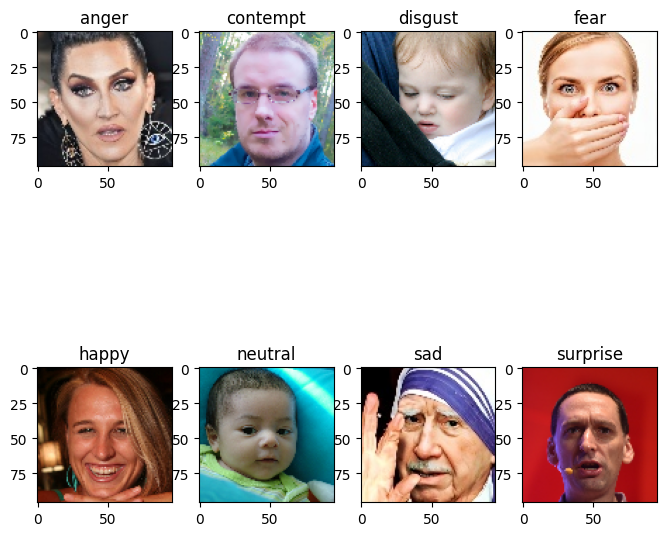

In [4]:
fig = plt.figure(figsize=(8, 8))
rows = 2
columns = 4
for i in range(1, columns*rows + 1):
  ax = plt.subplot(rows, columns, i)
  ax.set_title(samples[i-1][1])
  img = np.asarray(Image.open(samples[i-1][0]))
  ax.imshow(img)
plt.show()

(96, 96, 3)


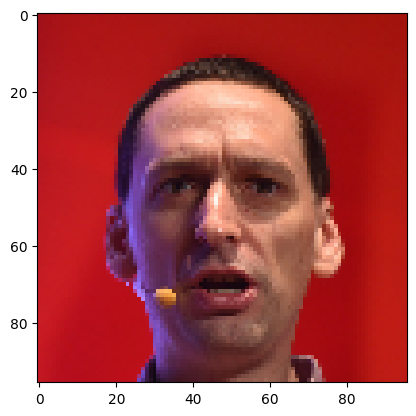

In [5]:
test_img = np.copy(img)
print(test_img.shape)
plt.imshow(test_img)

96 x 96 images, so we can start with 144 (12 * 12) patches of size 8 x 8 

In [6]:
IMG_SIZE = 96
PATCH_SIZE = 8
NB_PATCH_SQRT = IMG_SIZE // PATCH_SIZE

In [7]:
def draw_patches(img: np.array) -> np.array:
  image = np.copy(img)
  for i in range(0, NB_PATCH_SQRT):
    for j in range(0, NB_PATCH_SQRT, 2):
      if i % 2 == 0:
        image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, j * PATCH_SIZE : (j + 1) * PATCH_SIZE] = image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, j * PATCH_SIZE : (j + 1) * PATCH_SIZE] / 2
      else:
        image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, (j + 1) * PATCH_SIZE : (j + 2) * PATCH_SIZE] = image[i * PATCH_SIZE : (i + 1) * PATCH_SIZE, (j + 1) * PATCH_SIZE : (j + 2) * PATCH_SIZE] / 2
  return image

Patch representation on sample image

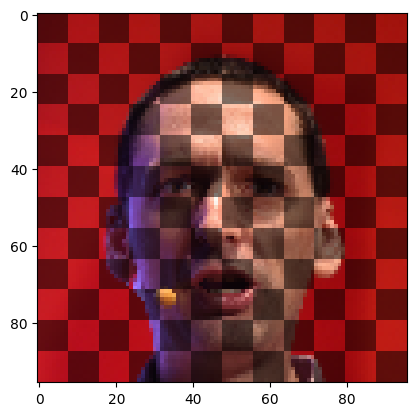

In [8]:
plt.imshow(draw_patches(test_img))

In [9]:
def random_mask_on_pixels(img: np.array) -> np.array:
  image = np.copy(img)
  aspect_ratio_range = [0.75, 1.5]
  scale_range = [0.15, 0.2]

  ar = np.random.uniform(*aspect_ratio_range)
  s = np.random.uniform(*scale_range)

  area = s * (IMG_SIZE ** 2)
  height = int(round(np.sqrt(area / ar)))
  width = int(round(np.sqrt(area * ar)))

  x, y = np.random.randint(low=IMG_SIZE - width + 1), np.random.randint(low=IMG_SIZE - height + 1)

  image[y : y + height, x : x + width] = image[y : y + height, x : x + width] / 2
  return image

In [10]:
def show_patch_corner(img: np.array) -> np.array:
  image = np.copy(img)
  for i in range(0, NB_PATCH_SQRT):
    for j in range(0, NB_PATCH_SQRT):
      image[i * PATCH_SIZE, j * PATCH_SIZE] = np.array([255, 255, 255])
  return image

Single mask (pixel level) on sample image

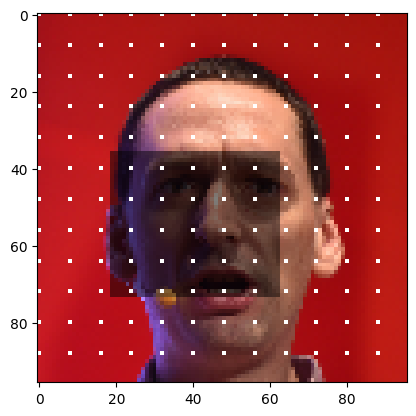

In [11]:
plt.imshow(show_patch_corner(random_mask_on_pixels(test_img)))

In [12]:
def random_mask_on_patch(img: np.array, aspect_ratio_range: List[float] = [0.75, 1.5], scale_range: List[float] = [0.15, 0.2]) -> np.array:
  image = np.copy(img)

  ar = np.random.uniform(*aspect_ratio_range)
  s = np.random.uniform(*scale_range)

  area = s * (NB_PATCH_SQRT ** 2)
  height = int(round(np.sqrt(area / ar)))
  width = int(round(np.sqrt(area * ar)))

  x, y = np.random.randint(low=NB_PATCH_SQRT - width + 1), np.random.randint(low=NB_PATCH_SQRT - height + 1)

  image[y * PATCH_SIZE : (y + height) * PATCH_SIZE, x * PATCH_SIZE : (x + width) * PATCH_SIZE] = image[y * PATCH_SIZE : (y + height) * PATCH_SIZE, x * PATCH_SIZE : (x + width) * PATCH_SIZE] / 2
  mask_indexes = torch.cat([torch.arange(x, x + width) + i * NB_PATCH_SQRT for i in range(y, y + height)])

  return image, (x, y, width, height, mask_indexes)

Single mask (patch level) on sample image, this is the mask we will keep to **train** our model

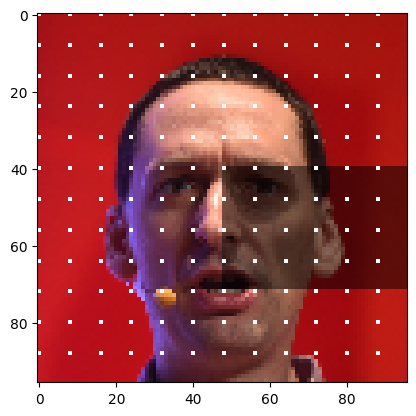

In [13]:
plt.imshow(show_patch_corner(random_mask_on_patch(test_img)[0]))

In [14]:
def M_mask(img: np.array, M: int = 4) -> np.array:
  image = np.copy(img)
  masks = []

  for _ in range(M):
    image, mask_info = random_mask_on_patch(image)
    masks.append(mask_info)
    print(mask_info)

  return image

Multiple (4 as stated in the paper) masks on sample image

(7, 7, 5, 5, tensor([ 91,  92,  93,  94,  95, 103, 104, 105, 106, 107, 115, 116, 117, 118,
        119, 127, 128, 129, 130, 131, 139, 140, 141, 142, 143]))
(1, 6, 5, 5, tensor([ 73,  74,  75,  76,  77,  85,  86,  87,  88,  89,  97,  98,  99, 100,
        101, 109, 110, 111, 112, 113, 121, 122, 123, 124, 125]))
(4, 7, 4, 5, tensor([ 88,  89,  90,  91, 100, 101, 102, 103, 112, 113, 114, 115, 124, 125,
        126, 127, 136, 137, 138, 139]))
(2, 4, 5, 4, tensor([50, 51, 52, 53, 54, 62, 63, 64, 65, 66, 74, 75, 76, 77, 78, 86, 87, 88,
        89, 90]))


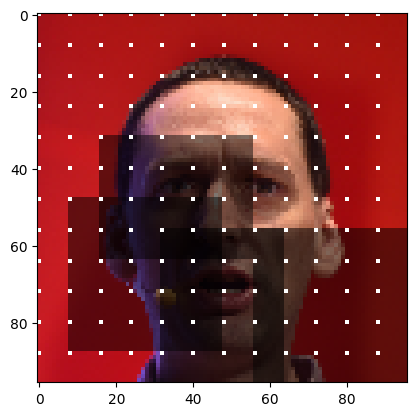

In [15]:
plt.imshow(show_patch_corner(M_mask(test_img)))

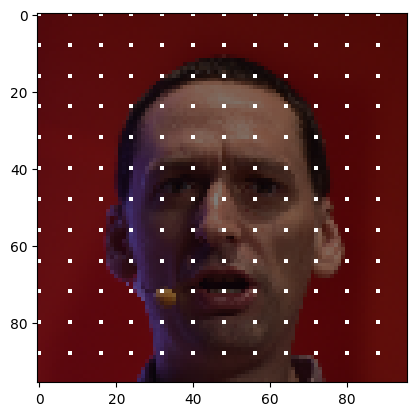

In [16]:
plt.imshow(show_patch_corner(random_mask_on_patch(test_img, scale_range=[0.85, 1], aspect_ratio_range=[1,1])[0]))

In [17]:
def mask_and_context(img: np.array, M: int = 4): 
  image = np.copy(img)
  indexes_masks = set()
  fig = plt.figure(figsize=(20, 12))

  for _ in range(M):
    image, mask_info = random_mask_on_patch(image)
    indexes_masks.update(mask_info[4].tolist())

  image_context, mask_context = random_mask_on_patch(np.copy(img), scale_range=[0.85, 1], aspect_ratio_range=[1,1])
  indexes_context = set(mask_context[4].tolist())

  fig.add_subplot(1, 3, 1)
  plt.imshow(image)
  fig.add_subplot(1, 3, 2)
  plt.imshow(image_context)

  final_indexes = indexes_context - indexes_masks
  image_final_context = np.copy(img)
  for i in final_indexes:
    image_final_context[(i // NB_PATCH_SQRT) * PATCH_SIZE : (i // NB_PATCH_SQRT + 1) * PATCH_SIZE, (i % NB_PATCH_SQRT) * PATCH_SIZE : (i % NB_PATCH_SQRT + 1) * PATCH_SIZE] = image_final_context[(i // NB_PATCH_SQRT) * PATCH_SIZE : (i // NB_PATCH_SQRT + 1) * PATCH_SIZE, (i % NB_PATCH_SQRT) * PATCH_SIZE : (i % NB_PATCH_SQRT + 1) * PATCH_SIZE] // 2

  fig.add_subplot(1, 3, 3)
  plt.imshow(image_final_context)
  
  plt.show()

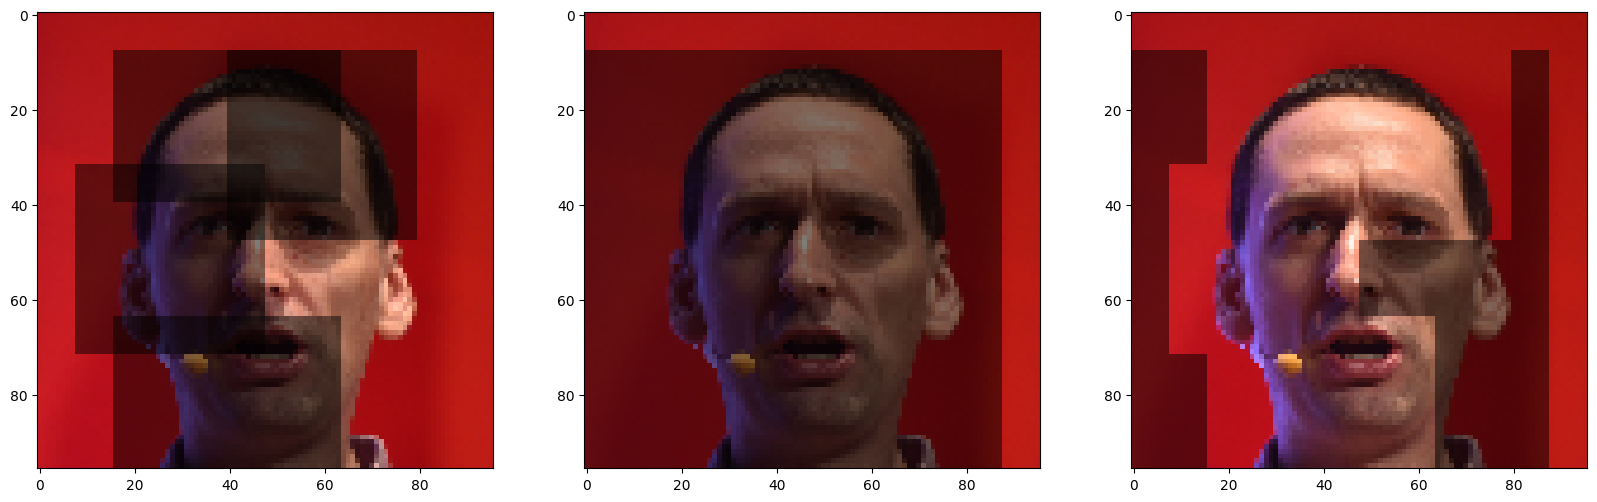

In [18]:
mask_and_context(test_img)

In [11]:
import pandas as pd
import torch
import os
import numpy as np

from torch.utils.data import Dataset
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
from typing import Tuple


class AffectNetDataset(Dataset):
    def __init__(
        self,
        dataset_path: str,
        labels_filename: str,
        img_size: int,
        patch_size: int,
        nb_mask: int = 4,
        aspect_ratio_range_mask: Tuple[int, int] = (0.75, 1.5),
        scale_range_mask: Tuple[int, int] = (0.15, 0.2),
        aspect_ratio_range_context: Tuple[int, int] = (
            1.0,
            1.0,
        ),  # unit aspect ratio for context
        scale_range_context: Tuple[int, int] = (0.85, 1.0),
    ):
        self.df = pd.read_csv(os.path.join(dataset_path, labels_filename))
        self.dataset_path = dataset_path

        self.img_size = img_size
        self.patch_size = patch_size
        self.sqrt_count_patch = img_size // patch_size
        self.nb_mask = nb_mask

        self.aspect_ratio_range_mask = aspect_ratio_range_mask
        self.scale_range_mask = scale_range_mask

        self.aspect_ratio_range_context = aspect_ratio_range_context
        self.scale_range_context = scale_range_context

    def __len__(self):
        """
        Returns the length of the dataset, which is the length of `df`.
        """
        return len(self.df)

    def get_random_width_and_height(self, n: int):
        """
        Returns a random height and weight based on a random aspect ratio and a random scale.\\
        Length of height and width is `n+1`, the first `n` elements being masks height and width, and the last one being the context height and weight.

        Parameters:
        - `n`: the number of height and width to be generated. 
        """
        aspect_ratio = torch.FloatTensor(n).uniform_(*self.aspect_ratio_range_mask)
        scale = torch.FloatTensor(n).uniform_(*self.scale_range_mask)

        aspect_ratio = torch.cat(
            [aspect_ratio,
            torch.FloatTensor(1).uniform_(*self.aspect_ratio_range_context)]
        )
        scale = torch.cat(
            [scale, torch.FloatTensor(1).uniform_(*self.scale_range_context)]
        )

        # calculate area, width and height of each mask and context
        area = scale * (self.sqrt_count_patch**2)
        height = torch.sqrt(area / aspect_ratio).round().int()
        width = torch.sqrt(area * aspect_ratio).round().int()

        return height, width

    def __getitem__(self, idx):
        """
        Returns a tuple of 3 elements:
        -
        -
        -
        """
        img_path = os.path.join(self.dataset_path, self.df.iloc[idx]["pth"])
        img = pil_to_tensor(Image.open(img_path))  # 96 x 96 x 3

        # random height and width for masks
        heights, widths = self.get_random_width_and_height(self.nb_mask)
        xs = np.random.randint(low=self.sqrt_count_patch - widths[:-1].int() + 1)
        ys = np.random.randint(low=self.sqrt_count_patch - heights[:-1].int() + 1)

        # calculate patch indexes of mask
        masks = []
        masks_indexes = set()
        z = zip(xs, ys, heights[:-1], widths[:-1])
        for x, y, height, width in z:
            tmp_mask = torch.cat(
                [
                    torch.arange(x, x + width) + (y + i) * self.sqrt_count_patch
                    for i in range(height)
                ]
            )

            masks_indexes.update(tmp_mask.tolist())
            masks.append(tmp_mask)

        context_indexes = set(
            torch.cat(
                [
                    torch.arange(xs[-1], xs[-1] + widths[-1])
                    + (ys[-1] + i) * self.sqrt_count_patch
                    for i in range(heights[-1])
                ]
            ).tolist()
        )

        return (
            # img.view(  # 144 x 8 x 8 x 3
            #     self.sqrt_count_patch**2,
            #     self.patch_size,
            #     self.patch_size,
            #     3,
            # ),
            img,
            context_indexes - masks_indexes,
            masks,
        )

In [12]:
dataset = AffectNetDataset(
    dataset_path=os.path.join("..", "dataset", "archive"),
    labels_filename="labels.csv",
    img_size=96,
    patch_size=8,
)

In [13]:
dataset[0]

(tensor([[[94, 91, 84,  ..., 41, 42, 42],
          [92, 88, 81,  ..., 39, 40, 40],
          [88, 84, 75,  ..., 38, 38, 39],
          ...,
          [17, 18, 18,  ..., 33, 41, 33],
          [18, 18, 18,  ..., 25, 27, 25],
          [16, 17, 18,  ..., 19, 25, 19]],
 
         [[70, 68, 65,  ..., 45, 46, 46],
          [69, 68, 64,  ..., 43, 44, 44],
          [68, 65, 60,  ..., 42, 42, 43],
          ...,
          [20, 21, 21,  ..., 36, 45, 37],
          [21, 21, 21,  ..., 29, 31, 29],
          [19, 20, 21,  ..., 23, 29, 23]],
 
         [[60, 60, 58,  ..., 57, 58, 58],
          [61, 59, 57,  ..., 55, 56, 56],
          [61, 58, 53,  ..., 53, 53, 54],
          ...,
          [29, 30, 28,  ..., 45, 54, 46],
          [30, 30, 30,  ..., 40, 42, 40],
          [28, 29, 30,  ..., 34, 40, 34]]], dtype=torch.uint8),
 {60,
  61,
  71,
  72,
  73,
  83,
  84,
  85,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  1